In [1]:
import sys
sys.path.append("..")

%load_ext autoreload
%autoreload 2

import itertools
import re
import gc
import nltk
import collections
from functools import partial

from nltk.corpus import stopwords
from tqdm.notebook import tqdm, trange
from scipy import sparse
import numpy as np
import pandas as pd
import pygsp
import seaborn as sns

from sklearn import cluster
from sklearn.manifold import SpectralEmbedding
import matplotlib.pyplot as plt

import torch
from torch import nn, autograd
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from src.graph_regularization import *

%config Completer.use_jedi = False

dev = 'cuda:0'

In [2]:
class Net(nn.Module):
    def __init__(self, layers, drop_p=0.2):
        super(Net,self).__init__()
        self.hidden = nn.ModuleList()
        for li,lo in zip(layers, layers[1:]):
            self.hidden.append(nn.Linear(li, lo))
        self.droput = nn.Dropout(drop_p)
        
    def forward(self,x):
        x = x.view(-1, INPUT_SHAPE)
        for i,l in enumerate(self.hidden):
            x = l(x)
            if i < len(self.hidden) - 1:
                x = self.droput(F.relu(x))
        return x

def eval_nn(nn, testloader):
    correct = 0
    loss_sublist = []
    for x,y in testloader:
        x,y = x.to(dev), y.to(dev)
        nn.eval()
        z = nn(x)
        _, yh = torch.max(z.data, 1)
        correct += (yh == y).sum().item()
        loss_sublist.append(crit(z, y).data.item())
    acc = correct / n_test
    return acc, round(np.mean(loss_sublist), 4)

def run_nn_train(nn, x, y, optimizer, crit):
    x,y = x.to(dev), y.to(dev)
    nn.train()
    optimizer.zero_grad()
    z = nn(x)
    return crit(z, y)

def clean_mem():
    gc.collect()
    torch.cuda.empty_cache()

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainset_raw = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, shuffle=True, num_workers=12)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024, shuffle=False, num_workers=12)

INPUT_SHAPE = 1 * 28 * 28
OUTPUT_SHAPE = 10

## Simple MLP

In [15]:
layers = [INPUT_SHAPE, 40, 40, 30, OUTPUT_SHAPE]
mlp = Net(layers, drop_p=0.3).to(dev)

crit = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

In [16]:
%%time

N_EPOCHS = 20
train_loss_list = []
test_loss_list = []
accuracy_list = []
correct = 0
n_test = len(testset)
graph = None

for e in range(N_EPOCHS):
    activations = collections.defaultdict(list)
    # Train
    loss_sublist = []
    gl_sublist = []
    for x,y in trainloader:
        loss = run_nn_train(mlp, x, y, optimizer=optimizer, crit=crit)
        loss_sublist.append(loss.data.item())

        loss.backward()
        optimizer.step()
        
    train_loss_list.append(np.mean(loss_sublist))

    # Test
    acc, test_loss = eval_nn(mlp, testloader)
    del x,y,loss
    clean_mem()

    test_loss_list.append(test_loss)
    print(f'{e}. Accuracy: {round(acc, 4)}, CE: {test_loss_list[-1]}')

0. Accuracy: 0.7277, CE: 0.8428
1. Accuracy: 0.7804, CE: 0.6009
2. Accuracy: 0.8006, CE: 0.5413
3. Accuracy: 0.8146, CE: 0.5147
4. Accuracy: 0.8269, CE: 0.4867
5. Accuracy: 0.8331, CE: 0.469
6. Accuracy: 0.8374, CE: 0.4563
7. Accuracy: 0.8386, CE: 0.4478
8. Accuracy: 0.8436, CE: 0.4353
9. Accuracy: 0.8463, CE: 0.4337
10. Accuracy: 0.8487, CE: 0.4217
11. Accuracy: 0.8503, CE: 0.417
12. Accuracy: 0.8491, CE: 0.4153
13. Accuracy: 0.8521, CE: 0.4092
14. Accuracy: 0.8574, CE: 0.4044
15. Accuracy: 0.8516, CE: 0.4086
16. Accuracy: 0.8547, CE: 0.4037
17. Accuracy: 0.8535, CE: 0.4039
18. Accuracy: 0.8548, CE: 0.4007
19. Accuracy: 0.8565, CE: 0.3956
CPU times: user 24.8 s, sys: 13.5 s, total: 38.3 s
Wall time: 1min 4s


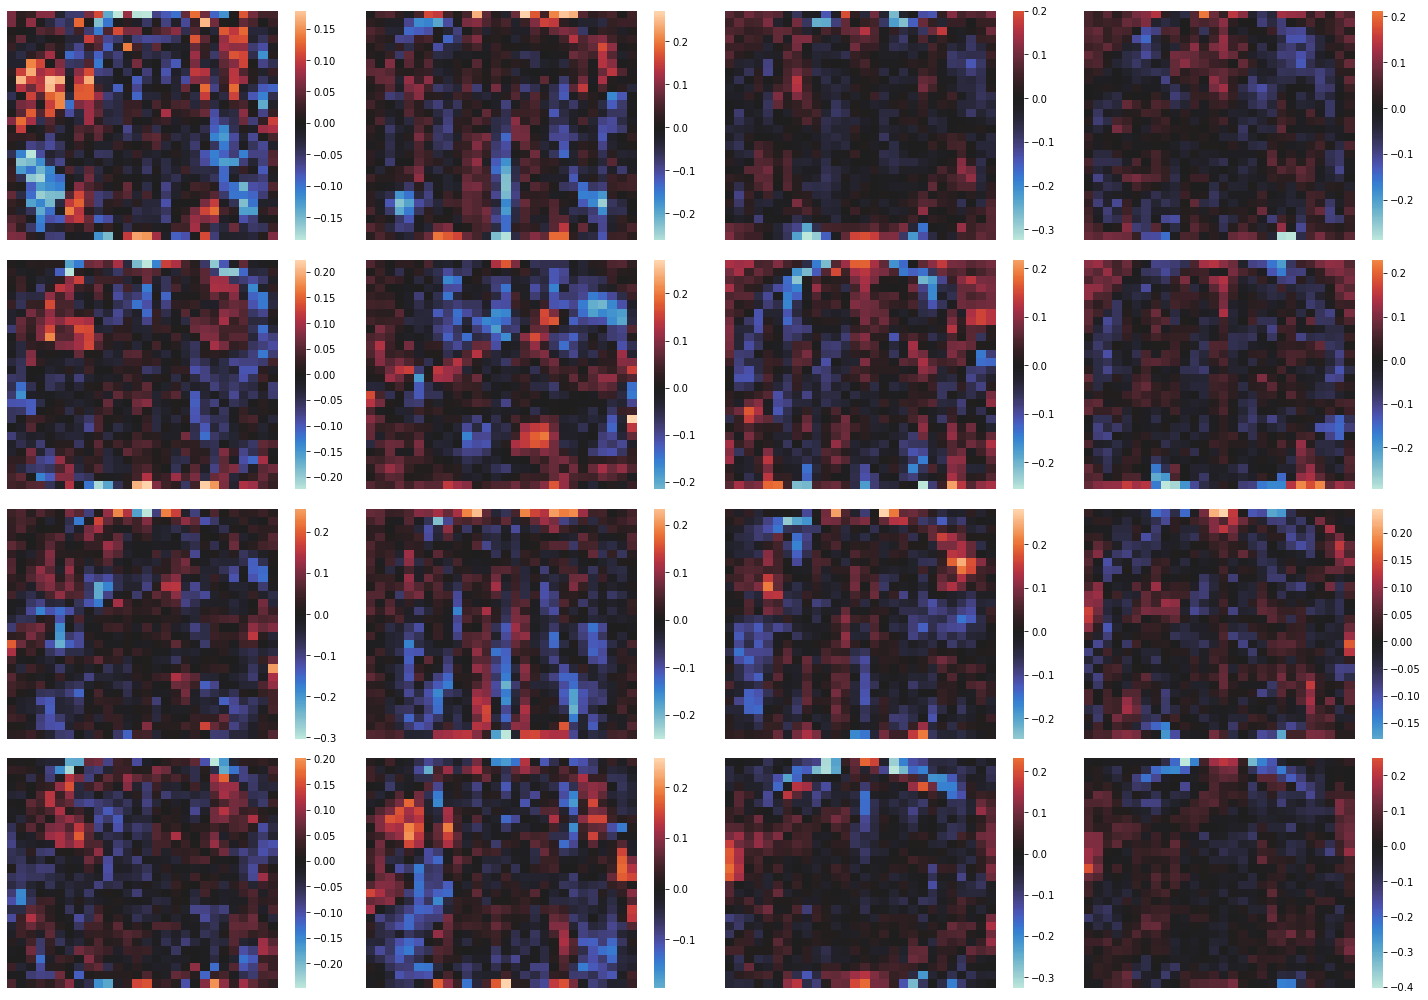

In [19]:
l1 = dict(mlp.named_modules())['hidden.0']
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 14))
for i in range(16):
    sns.heatmap(list(l1.parameters())[0][i,:].reshape(28, 28).cpu().detach().numpy(), xticklabels=False, yticklabels=False, center=0, ax=axes.flatten()[i])

plt.tight_layout()

## Graph MLP

In [64]:
layers = [INPUT_SHAPE, 40, 40, 30, OUTPUT_SHAPE]
ids_per_layer = [sum(layers[1:(i+1)]) + np.arange(layers[i+1], dtype=int) for i in range(n_hidden)]

graph_mlp = Net(layers, drop_p=0.3).to(dev)

crit = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(graph_mlp.parameters(), lr=0.001)

activations = collections.defaultdict(list)
def save_activation(name, mod, inp, out):
    activations[name].append(out.cpu())

for name, m in graph_mlp.named_modules():
    if type(m)==nn.Linear:
        m.register_forward_hook(partial(save_activation, name))

In [65]:
%%time

N_EPOCHS = 20
train_loss_list = []
test_loss_list = []
accuracy_list = []
correct = 0
n_test = len(testset)
lap = None
n_hidden = len(layers) - 2

for e in range(N_EPOCHS):
    activations = collections.defaultdict(list)
    # Train
    loss_sublist = []
    gl_sublist = []
    for x,y in trainloader:
        loss = run_nn_train(graph_mlp, x, y, optimizer=optimizer, crit=crit)
        loss_sublist.append(loss.data.item())

        if lap is not None:
            gl = graph_loss(torch.hstack([activations[f'hidden.{li}'][-1] for li in range(n_hidden)]), lap) * 0.005
            gl_sublist.append(gl.data.item())
            loss += gl

        loss.backward()
        optimizer.step()
        
    train_loss_list.append(np.mean(loss_sublist))
    
    # Loss update
    embs = [torch.vstack(activations[f'hidden.{i}']).T.detach().numpy() for i in range(n_hidden)]
    adj_mat = create_graph_from_layered_embedding(embs, frac=0.3)
    graph = pygsp.graphs.Graph(adj_mat)
    graph.compute_laplacian(lap_type='normalized')
    lap = torch.Tensor(graph.L.A)

    # Test
    acc, test_loss = eval_nn(graph_mlp, testloader)
    del x,y,loss
    clean_mem()

    if len(gl_sublist) > 0:
        print(f'{e}. Accuracy: {round(acc, 4)}, CE: {test_loss}, GL: {round(np.mean(gl_sublist), 3)}')
    else:
        print(f'{e}. Accuracy: {round(acc, 4)}, CE: {test_loss}')

0. Accuracy: 0.6983, CE: 0.8446
1. Accuracy: 0.4489, CE: 2.0192, GL: 6.652
2. Accuracy: 0.4949, CE: 1.5052, GL: 0.426
3. Accuracy: 0.5613, CE: 1.2886, GL: 0.331
4. Accuracy: 0.6552, CE: 1.179, GL: 0.288
5. Accuracy: 0.6757, CE: 1.0966, GL: 0.261
6. Accuracy: 0.6708, CE: 1.0418, GL: 0.249
7. Accuracy: 0.7071, CE: 0.9639, GL: 0.239
8. Accuracy: 0.7234, CE: 0.9203, GL: 0.232
9. Accuracy: 0.7244, CE: 0.8864, GL: 0.225
10. Accuracy: 0.7385, CE: 0.8307, GL: 0.22
11. Accuracy: 0.7275, CE: 0.8077, GL: 0.221
12. Accuracy: 0.7544, CE: 0.784, GL: 0.213
13. Accuracy: 0.7462, CE: 0.7766, GL: 0.212
14. Accuracy: 0.7686, CE: 0.7373, GL: 0.213
15. Accuracy: 0.7778, CE: 0.7199, GL: 0.209
16. Accuracy: 0.7818, CE: 0.7024, GL: 0.206
17. Accuracy: 0.7803, CE: 0.6948, GL: 0.204
18. Accuracy: 0.7677, CE: 0.7029, GL: 0.2
19. Accuracy: 0.7715, CE: 0.6792, GL: 0.206
CPU times: user 4min 7s, sys: 26.3 s, total: 4min 33s
Wall time: 1min 35s


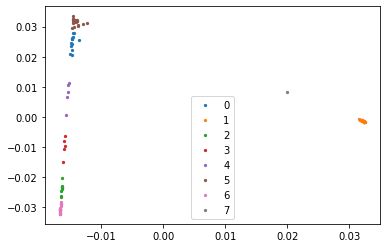

In [67]:
embs = [torch.vstack(activations[f'hidden.{i}']).T.detach().numpy() for i in range(n_hidden)]
adj_mat = create_graph_from_layered_embedding(embs, frac=0.3)

spec_emb = SpectralEmbedding(affinity='precomputed').fit_transform(adj_mat)
clust_labels = cluster.k_means(spec_emb, 8)[1]

for i in set(clust_labels):
    mask = (clust_labels == i)
    plt.scatter(spec_emb[mask,0], spec_emb[mask,1], s=5, label=i)
plt.legend();

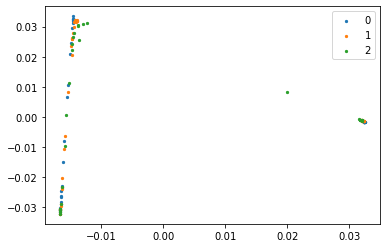

In [68]:
for i,ids in enumerate(ids_per_layer):
    plt.scatter(spec_emb[ids,0], spec_emb[ids,1], s=5, label=i)
plt.legend();

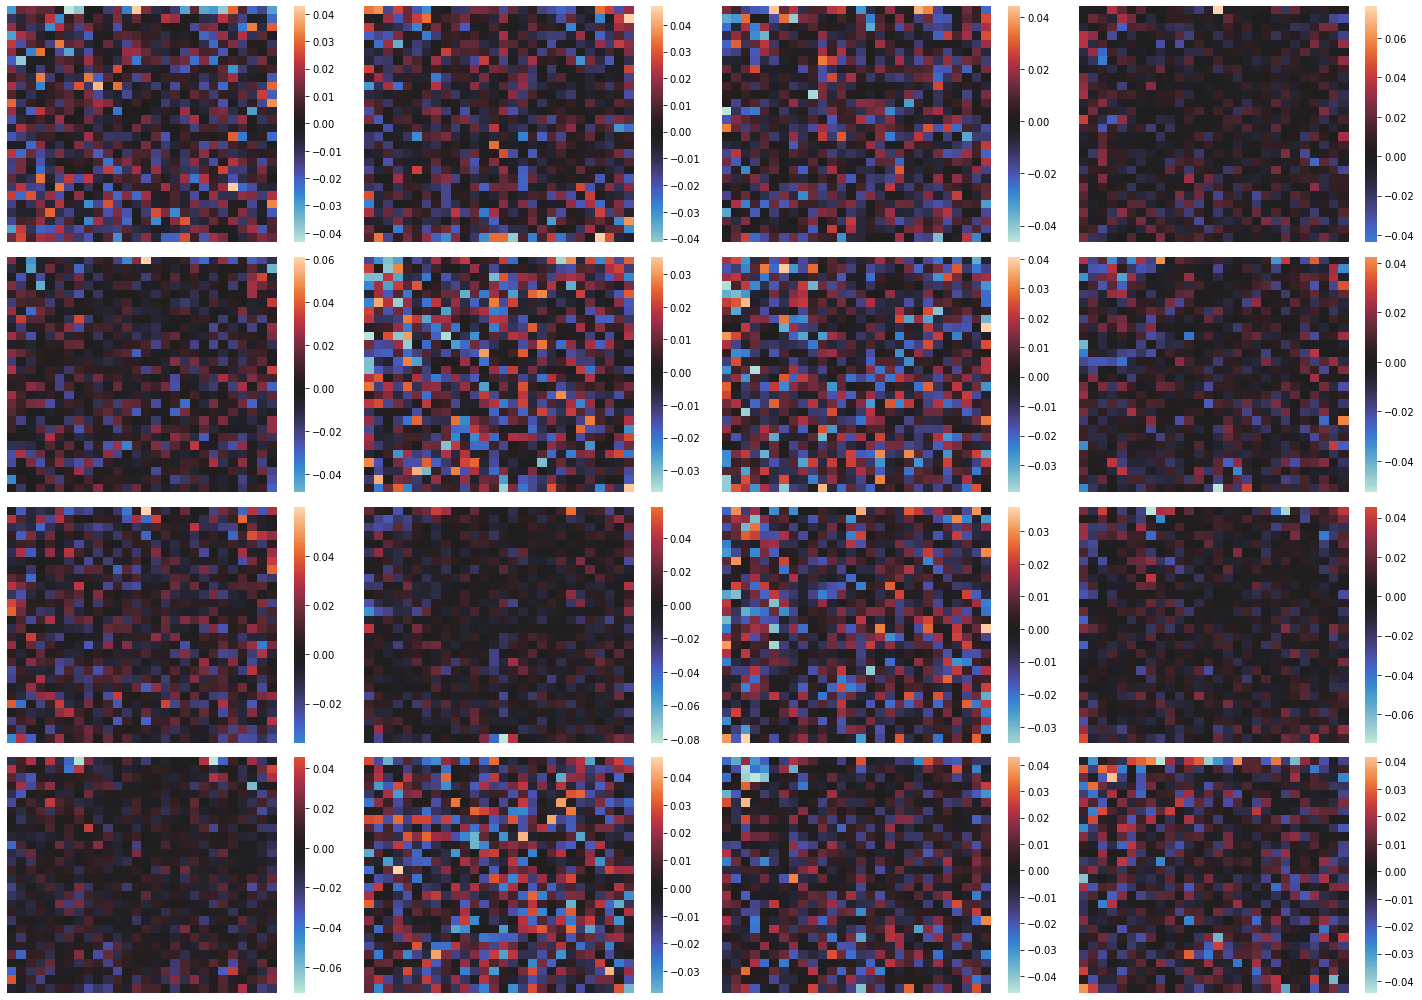

In [69]:
l1 = dict(graph_mlp.named_modules())['hidden.0']
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 14))
for i in range(16):
    sns.heatmap(list(l1.parameters())[0][i,:].reshape(28, 28).cpu().detach().numpy(), xticklabels=False, yticklabels=False, center=0, ax=axes.flatten()[i])

plt.tight_layout()